In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip install konlpy JPype1-py3 
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
!pip install transformers
!pip install --upgrade mxnet gluonnlp
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master
!pip install sentencepiece
!pip install datasets
!pip install bert_score

### ARGUMENT

In [ ]:
class args():
  gpu = '0'
  seed = 0
  corpus = '/content/drive/MyDrive/dacon/KoreanLanguage/data/CORPUS/ko_corpus.txt'

  # Tokenizer Setting
  tok = 'SP_BPE' # BERT_WORD, CH_BPE, BYTE_BPE
  epochs=2
  batch_size=16
  weight_decay=0.01
  n_fold=5
  fold=list(range(n_fold))

  # MODEL SETTING
  pt = 'klue/roberta-large'
  out_dir = f"/content/drive/MyDrive/dacon/KoreanLanguage/ckpt/roberta/{pt}/"

  linear_dim = 1034 * 3
  reinit_pooler = True
  reinit_linear = 10 # 이 부분을 계속 바꿔가면서 실험을 해 보자

  max_len = 128
  start_lr = 5e-5
  min_lr = 1e-6

data_dir = '/content/drive/MyDrive/dacon/KoreanLanguage/data'
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")


### IMPORTS

In [ ]:
# LIBRARY IMPORTS
import numpy as np
import pandas as pd
import os, sys
import pickle
import re
import cv2
from tqdm import tqdm, tqdm_notebook
# PYTORCH
import torch
import torch.nn as nn
import torch.cuda.amp as amp

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import *

from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, MultiStepLR, OneCycleLR

# UTILS
import math, tqdm, random
from torch.optim.optimizer import Optimizer, required
from collections import defaultdict
import itertools as it
import sentencepiece as spm
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.model_selection import KFold, StratifiedKFold 
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# TRANSFORMER
import transformers
from transformers import XLMPreTrainedModel, XLMRobertaModel, XLMRobertaConfig, XLMRobertaTokenizer, BertTokenizer
from transformers import XLMRobertaForSequenceClassification, BertForSequenceClassification
from transformers import AutoTokenizer
from transformers import BertForSequenceClassification, DistilBertForSequenceClassification, XLNetForSequenceClassification,XLMRobertaForSequenceClassification, XLMForSequenceClassification, RobertaForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup,get_cosine_with_hard_restarts_schedule_with_warmup, get_cosine_schedule_with_warmup


### LOADING DATAS

In [ ]:
# data loading
def load_dacon_data():
  data_dir = '/content/drive/MyDrive/dacon/KoreanLanguage/data'

  train = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))
  test = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))

  train = train[['label', 'premise', 'hypothesis']]
  test = test[['premise', 'hypothesis']]

  skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
  train['fold'] = -1 # 우선 모든 "fold"를 지정해 놓은 칼럼은 -1로 설정
  for n, (train_split, valid_split) in enumerate(skf.split(train, train['label'])):
    train.loc[valid_split, 'fold'] = n
  train['id'] = [x for x in range(len(train))]

  # returns the data int the dataframe form
  return train, test

def load_knli_data():
  """
  3개의 속성으로 한국어 문장을 분류하는데 사용이 되는 데이터를 txt데이터에 포함해 학습 시킬 생각이다.
  """
  data_dir = '/content/drive/MyDrive/dacon/KoreanLanguage/data/KorNLI'
  seqs = []
  files = ['snli_1.0_train.ko.tsv','xnli.dev.ko.tsv','xnli.test.ko.tsv']

  for f in files:
    df = pd.read_csv(os.path.join(data_dir, f), delimiter = '\t')
    seqs.extend(list(set(list(df['sentence1']))))
    seqs.extend(list(set(list(df['sentence2']))))

  return seqs

def load_news_data():
  """
  대회의 데이터로 주어진 것과 제일 유사도가 높은 텍스트를 가지는 것이
  뉴스데이터로 판단이 되어서 뉴스 말뭉치를 사용해 볼 생각이다.
  """
  data_dir = '/content/drive/MyDrive/dacon/KoreanLanguage/data/pretraining/news'
  seqs, files = [], os.listdir(data_dir)
  for f in files:
    if (os.path.splitext(f)[-1]) == '.csv':
      df = pd.read_csv(os.path.join(data_dir, f))
      seqs.extend(list(df['원문']))
  
  return seqs

def load_kowiki_data():
  """
  kowiki 텍스트 데이터의 경우에는 이미 일반적인 형태로 바뀌어 있는 상태이기 때문에 굳이 전처리가 따로 필요하지는 않다.
  """
  data_dir = '/content/drive/MyDrive/dacon/KoreanLanguage/data/kowiki.txt'
  seqs = []
  with open(data_dir, 'r') as fr:
    for idx, line in enumerate(fr):
      seqs.append(line)
  
  return seqs

def load_communication_data(into_one = True):
  """
  엑셀파일이었는데 csv파일로 바꾸어서 사용
  여러개의 csv파일이 존재하는데 이에 대해서 하나의 csv파일과 txt파일로 합쳐 주려고 한다.
  모든 문장을 리스트의 형태로 담아서 반환한다.
  """
  data_dir = '/content/drive/MyDrive/dacon/KoreanLanguage/data/pretraining/communication'
  files = os.listdir(data_dir)
  seqs = []
  for f in files:
    df = pd.read_csv(os.path.join(data_dir, f))
    seqs.extend(list(df['SENTENCE']))

  return seqs

### OVERALL FLOW
1. Hugging Face API의 `WordPieceTokenizer`을 사용할지 Google의 `SentencePiece` API를 사용할지 고민 중이다.
2. 각각의 tokenizer이 어떻게 작동하는지, 그리고 모델에 입력이 되었을 때에 어떻게 출력을 내는지 확인해 보아야 한다.
3. 단어의 개수는 32000개가 제일 학습 성능이 좋다고 하며, 사전에 한국어 문장 뭉치의 전처리를 어떤식으로 할지 생각해 보아야 한다.
  - 본래 sequence classification task를 fine-tuning 하기 전에 우선 wiki와 news dataset corpus를 사용해서 학습을 시켜야 한다.

4. 이미 사전 학습이 되어있는 tokenizer들을 보면 대부분이 raw corpus의 한국어 말뭉치를 기반으로 tokenizer을 학습 시킨 것으로 보아 굳이 사전 preprocessing의 과정은 필요가 없어 보였다.
5. 물론 `Hugging Face` API를 사용하고자 한다면 hugging face tokenizer을 사용하는 것이 더 의미있을 수도 있지만 사실상 sentencepiece는 한국어에 적용할 때에 내부 단어 분리를 위해 매우 유용한 패키지임은 틀림없다.

6. train, test를 위한 문장들을 확인해 본 결과 일상적인 대화보다는 korean wikipedia와 news article 데이터셋을 pretraining에 사용하는 것이 의미있어 보였다.


### TOKENIZERS

In [ ]:
def preprocessing(text):
  import re
  # 괄호와 그 내부에 있는 내용은 모두 없애줌 -> train데이터에도 없을 예정이기 때문이다.
  regex = "\([^)]*\)"
  text = re.sub(regex, '', text)

  # 영어, 숫자, 한글 이외에는 모두 제거
  # 정규 표현식 처리할때에 주의하도록 하자 -> 힗으로 표현해서 틀림
  text =  re.sub('[^0-9a-zA-Zㄱ-힣.,!?]',' ',text)
  # 숫자 정보는 모두 *으로 대체
  text = re.sub('[0-9]+','*', text)
  return text

In [ ]:
import sentencepiece as spm
corpus_dir = '/content/drive/MyDrive/dacon/KoreanLanguage/data/CORPUS/corpus.txt'

with open(corpus_dir, 'r') as r:
  text = r.read().split('\n')

In [ ]:
for idx, line in enumerate(text):
  print(preprocessing(line))
  if idx == 10:break

지미 카터
제임스 얼  지미  카터 주니어는 민주당 출신 미국 *번째 대통령 이다.
지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함 원자력 잠수함의 승무원으로 일하였다. *년 미국 해군 대위로 예편하였고 이후 땅콩 면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이  땅콩 농부  로 알려졌다.
*년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, *년 조지아 주 지사 선거에 낙선하지만 *년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, *년부터 *년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.
*년 대통령 선거에 민주당 후보로 출마하여 도덕주의 정책으로 내세워, 포드를 누르고 당선되었다.
카터 대통령은 에너지 개발을 촉구했으나 공화당의 반대로 무산되었다.
카터는 이집트와 이스라엘을 조정하여, 캠프 데이비드에서 안와르 사다트 대통령과 메나헴 베긴 수상과 함께 중동 평화를 위한 캠프데이비드 협정을 체결했다.
그러나 이것은 공화당과 미국의 유대인 단체의 반발을 일으켰다. *년 백악관에서 양국 간의 평화조약으로 이끌어졌다. 또한 소련과 제*차 전략 무기 제한 협상에 조인했다.
카터는 *년대 후반 당시 대한민국 등 인권 후진국의 국민들의 인권을 지키기 위해 노력했으며, 취임 이후 계속해서 도덕정치를 내세웠다.
그러나 주 이란 미국 대사관 인질 사건에서 인질 구출 실패를 이유로 *년 대통령 선거에서 공화당의 로널드 레이건 후보에게 져 결국 재선에 실패했다. 또한 임기 말기에 터진 소련의 아프가니스탄 침공 사건으로 인해 *년 하계 올림픽에 반공국가들의 보이콧을 내세웠다.
지미 카터는 대한민국과의 관계에서도 중요한 영향을 미쳤던 대통령 중 하나다. 인권 문제와 주한미군 철수 문제로 한때 한미 관계가 불편하기도 했다. *년 대한민국에 대한 북한의 위협에 대비해 한미연합사를 창설하면

In [ ]:
with open('/content/drive/MyDrive/dacon/KoreanLanguage/data/CORPUS/ko_corpus.txt', 'w', encoding = 'utf-8') as w:
  for idx, line in enumerate(text):
    new_line = preprocessing(line)
    w.write(new_line)
    w.write('\n')
# 새로운 txt파일인 ko_corpus.txt에 괄호는 모두 제거하고 숫자 정보는 모두 특수 기호 하나로 바꾼 전처리된 텍스트를 저장하였다.

#### WORD-PIECE ENCODING TOKENIZER
- Huggingface에서 발표한 `Tokenizers`라이브러리를 사용하여 WordPiece Vocabulary를 만들게 되면 transformer model들과의 호환성도 보장할 수 있다.
- 또한 corpus가 매우 커도 별도의 메모리 문제가 발생하지는 않는다.
- 만약에 huggingface API를 사용해서 word piece tokenizer을 만들고 싶다면 BertTokenizer을 상속 받으면 된다.
- BPE와 달리 `<unk>` token이 존재한다는 단점이 있다.



> "We'll train a RoBERTa-like model, which is a BERT-like with a couple of changes"
```
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip install konlpy JPype1-py3 
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
```


In [ ]:
%%time

# load korean corpus
with open('/content/drive/MyDrive/dacon/KoreanLanguage/data/CORPUS/ko_corpus.txt', 'r', encoding = 'utf-8') as r:
  data = r.read().split('\n')
print(data[:3])

['지미 카터', '제임스 얼  지미  카터 주니어는 민주당 출신 미국 *번째 대통령 이다.', '지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함 원자력 잠수함의 승무원으로 일하였다. *년 미국 해군 대위로 예편하였고 이후 땅콩 면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이  땅콩 농부  로 알려졌다.']
CPU times: user 3.25 s, sys: 938 ms, total: 4.19 s
Wall time: 4.55 s


In [ ]:
from konlpy.tag import Mecab
mecab = Mecab().morphs
print('mecab_check : ', mecab(data[10]))

mecab_check :  ['지미', '카터', '는', '대한민국', '과', '의', '관계', '에서', '도', '중요', '한', '영향', '을', '미쳤', '던', '대통령', '중', '하나', '다', '.', '인권', '문제', '와', '주한', '미군', '철수', '문제', '로', '한때', '한미', '관계', '가', '불편', '하', '기', '도', '했', '다', '.', '*', '년', '대한민국', '에', '대한', '북한', '의', '위협', '에', '대비', '해', '한', '미연', '합사', '를', '창설', '하', '면서', ',', '*', '년', '까지', '*', '단계', '에', '걸쳐', '주한', '미군', '을', '철수', '하', '기', '로', '했', '다', '.', '그러나', '주한', '미군', '사령부', '와', '정보', '기관', '의회', '의', '반대', '에', '부딪혀', '주한', '미군', '은', '완전', '철수', '대신', '*,*', '명', '을', '감축', '하', '는', '데', '그쳤', '다', '.', '또한', '박정희', '정권', '의', '인권', '문제', '등', '과', '의', '논란', '으로', '불협화음', '을', '냈으나', ',', '*', '년', '*', '월', '하순', ',', '대한민국', '을', '방문', '하', '여', '관계', '가', '다소', '회복', '되', '었', '다', '.']


In [ ]:
%%time
# 해당 분절된 단어가 앞에 무언가가 붙어있었던 것인지 아닌지 확인해 주기 위해서는 각 조사의 앞에 ##를 붙여야 한다.
total_morphs = []

with open('/content/drive/MyDrive/dacon/KoreanLanguage/data/CORPUS/ko_corpus_mecab.txt', 'w', encoding = 'utf-8') as f:
  for idx, line in enumerate(data):
    morph_sentence = []
    lines = line.split(' ')
    for l in lines:
      cnt = 0
      morphs = mecab(l)
      for tok in morphs:
        save_tok = tok
        if cnt > 0:
          save_tok = "##" + save_tok
          morph_sentence.append(save_tok)
        else:
          morph_sentence.append(save_tok)
          cnt += 1

    f.write(' '.join(morph_sentence))
    f.write('\n')

CPU times: user 17min 51s, sys: 4.94 s, total: 17min 56s
Wall time: 17min 58s


In [ ]:
# mecab을 사용해서 형태소를 분절한 데이터를 저장하였으니 이를 다시 불러와서 읽고자 한다.
with open('/content/drive/MyDrive/dacon/KoreanLanguage/data/CORPUS/ko_corpus_mecab.txt', 'r', encoding = 'utf-8') as r:
  text = r.read().split('\n')

print(text[:5], len(text))

['지미 카터', '제임스 얼 지미 카터 주니어 ##는 민주당 출신 미국 * ##번 ##째 대통령 이 ##다 ##.', '지미 카터 ##는 조지아주 섬터 카운티 플 ##레인스 마을 ##에서 태어났 ##다 ##. 조지아 공과 ##대학교 ##를 졸업 ##하 ##였 ##다 ##. 그 후 해군 ##에 들어가 전함 원자력 잠수 ##함의 승무원 ##으로 일 ##하 ##였 ##다 ##. * ##년 미국 해군 대위 ##로 예 ##편하 ##였 ##고 이후 땅콩 면화 등 ##을 가꿔 많 ##은 돈 ##을 벌 ##었 ##다 ##. 그 ##의 별명 ##이 땅콩 농부 로 알려졌 ##다 ##.', '* ##년 조지아 주 상원 의원 선거 ##에서 낙선 ##하 ##나 그 선거 ##가 부정 ##선거 였음을 입증 ##하 ##게 되 ##어 당선 ##되 ##고 ##, * ##년 조지아 주 지사 선거 ##에 낙선 ##하 ##지만 * ##년 조지아 주 지사 ##를 역임 ##했 ##다 ##. 대통령 ##이 되 ##기 전 조지아주 상원 ##의원 ##을 두 ##번 연임 ##했으며 ##, * ##년 ##부터 * ##년 ##까지 조지아 지사 ##로 근무 ##했 ##다 ##. 조지아 주지사 ##로 지내 ##면서 ##, 미국 ##에 사 ##는 흑인 등 ##용법 ##을 내세웠 ##다 ##.', '* ##년 대통령 선거 ##에 민주당 후보 ##로 출마 ##하 ##여 도덕주의 정책 ##으로 내세워 ##, 포드 ##를 누르 ##고 당선 ##되 ##었 ##다 ##.'] 5134718


In [ ]:
# special token의 선언 -> BPE를 사용하는 것이 아니라면 unknown토큰은 생길 수 밖에 없다
## 1) 특별 토큰 정의하기
user_defined_symbols = ['[BOS]', '[EOS]', '[UNK0]', '[UNK1]', '[UNK2]', '[UNK3]', '[UNK4]', '[UNK5]', '[UNK6]',
                     '[UNK7]', '[UNK8]', '[UNK9]']
unused_token_num = 200
unused_list = ['[unused{}]'.format(n) for n in range(unused_token_num)]
user_defined_symbols.extend(unused_list)                   

In [ ]:
## 2) Hugging Face Tokenizer training
from tokenizers import BertWordPieceTokenizer, SentencePieceBPETokenizer, SentencePieceUnigramTokenizer, CharBPETokenizer, ByteLevelBPETokenizer

vocab_size = 32000
limit_alphabet = 6000
min_frequency = 5 # 단어의 최소 발생 빈도

# 한글의 전처리를 진행하는 것이기 때문에 cased model에 대해서 False로 설정해 주어야 한다.

tokenizer = BertWordPieceTokenizer(strip_accents = False, lowercase = False)

tokenizer.train(
    files = '/content/drive/MyDrive/dacon/KoreanLanguage/data/CORPUS/ko_corpus_mecab.txt',
    vocab_size = vocab_size,
    show_progress = True,
    min_frequency = min_frequency,
    limit_alphabet = limit_alphabet
)

In [ ]:
tok_path = '/content/drive/MyDrive/dacon/KoreanLanguage/tokenizer/32000/'
if not os.path.isdir(tok_path):
  os.mkdir(tok_path)

# google의 sentencepiece를 사용한것 과 달리 huggingface tokenizer과 transformer model을 사용할 수 있도록
# vocab.txt파일이 생성이 된다.
tokenizer.save_model(tok_path)

['/content/drive/MyDrive/dacon/KoreanLanguage/tokenizer/32000/vocab.txt']

In [ ]:
sentence = '나는 오늘 아침으로 그릭 요거트를 먹었다.'
outputs = tokenizer.encode(sentence)
print('=>idx : %s'%outputs.ids)
print('=>tokens : %s'%outputs.tokens)

=>idx : [3820, 6098, 8708, 9981, 20689, 3675, 6590, 5087, 6300, 6159, 6224, 4389, 6296, 6007, 9]
=>tokens : ['나', '##는', '오늘', '아침', '##으로', '그', '##릭', '요', '##거', '##트', '##를', '먹', '##었', '##다', '.']


In [ ]:
# 내가 새롭게 학습시킨 tokenizer이 과연 bert에 적용이 가능한지 확인해 보자
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer(
    vocab_file=  os.path.join(tok_path, 'vocab.txt'),
    strip_accents = False, do_lower_case = False,
    tokenize_chinese_chars=True
)

In [ ]:
train, test = load_dacon_data()
bert_tokenizer(preprocessing(train['premise'][0]))

{'input_ids': [2, 19482, 6077, 15003, 26238, 6203, 8104, 20237, 14278, 6098, 8036, 14190, 8076, 6690, 6114, 10307, 6203, 6187, 8, 8221, 22922, 21879, 17191, 3863, 6314, 18052, 6324, 4513, 26502, 22922, 12906, 6186, 6187, 9854, 8389, 6001, 6250, 4839, 6171, 6224, 19956, 6098, 3570, 6011, 6007, 9, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
bert_tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [ ]:
special_tokens_dict = {'additional_special_tokens' : user_defined_symbols}
bert_tokenizer.add_special_tokens(special_tokens_dict)

tok_path = '/content/drive/MyDrive/dacon/KoreanLanguage/tokenizer/32000'
bert_tokenizer.save_pretrained(tok_path + '_special')

('/content/drive/MyDrive/dacon/KoreanLanguage/tokenizer/32000_special/tokenizer_config.json',
 '/content/drive/MyDrive/dacon/KoreanLanguage/tokenizer/32000_special/special_tokens_map.json',
 '/content/drive/MyDrive/dacon/KoreanLanguage/tokenizer/32000_special/vocab.txt',
 '/content/drive/MyDrive/dacon/KoreanLanguage/tokenizer/32000_special/added_tokens.json')

#### SENTENCE PIECE TOKENIZER (BYTE-PAIR ENCODING)
- sentencepiece tokenizer을 사용하려 한다면 기존의 hugging face transformer 모델들에 곧바로 적용하는데에 한계가 있다.
- 따라서 이럴때는 MyTokenizer을 사용할 필요가 있다.

In [ ]:
import sentencepiece as spm

parameters = '--input={} \
--pad_id={} \
--bos_id={} \
--eos_id={} \
--unk_id={} \
--model_prefix={} \
--vocab_size={} \
--character_coverage={} \
--model_type={} \
--user_defined_symbols={}'

input_file = '/content/drive/MyDrive/dacon/KoreanLanguage/data/CORPUS/ko_corpus.txt'
tokenizer_path = '/content/drive/MyDrive/dacon/KoreanLanguage/tokenizer'
vocab_size = 32000 # 학습에 사용할 wordpiece의 개수
prefix = '/content/drive/MyDrive/dacon/KoreanLanguage/tokenizer/roberta_ko_ixxi' # 저장될 tokenizer의 이름
model_type = 'unigram' # default is unigram
pad = 0
bos = 1
eos = 2
unk = 3
char_cov = 1.0 # to reduce character set
user_defined_symbols = '[PAD],[UNK],[CLS],[SEP],[MASK],[BOS],[EOS],[UNK0],[UNK1],[UNK2],[UNK3],[UNK4],[UNK5],[UNK6],[UNK7],[UNK8],[UNK9],[unused0],[unused1],[unused2],[unused3],[unused4],[unused5],[unused6],[unused7],[unused8],[unused9],[unused10],[unused11],[unused12],[unused13],[unused14],[unused15],[unused16],[unused17],[unused18],[unused19],[unused20],[unused21],[unused22],[unused23],[unused24],[unused25],[unused26],[unused27],[unused28],[unused29],[unused30],[unused31],[unused32],[unused33],[unused34],[unused35],[unused36],[unused37],[unused38],[unused39],[unused40],[unused41],[unused42],[unused43],[unused44],[unused45],[unused46],[unused47],[unused48],[unused49],[unused50],[unused51],[unused52],[unused53],[unused54],[unused55],[unused56],[unused57],[unused58],[unused59],[unused60],[unused61],[unused62],[unused63],[unused64],[unused65],[unused66],[unused67],[unused68],[unused69],[unused70],[unused71],[unused72],[unused73],[unused74],[unused75],[unused76],[unused77],[unused78],[unused79],[unused80],[unused81],[unused82],[unused83],[unused84],[unused85],[unused86],[unused87],[unused88],[unused89],[unused90],[unused91],[unused92],[unused93],[unused94],[unused95],[unused96],[unused97],[unused98],[unused99]'
cmd = parameters.format(input_file, pad, bos, eos, unk, 
                        prefix, vocab_size, char_cov, model_type, user_defined_symbols)

# sentence piece tokenizer은 학습이 모두 완료 되면 True를 반환한다.
# 이 부분이 완료 되면 prefix로 지정해준 이름을 가진 파일 2개가 생성이 된다.
# model : 실제로 사용하는 tokenizer model
# vocab : 모델이 참조하는 단어 집합

spm.SentencePieceTrainer.Train(cmd)

In [ ]:
from transformers.file_utils import SPIECE_UNDERLINE
# make RoBERTa Tokenizer
import logging, os, unicodedata
from shutil import copyfile
import csv

from transformers import PreTrainedTokenizer

tokenizer_dir = '/content/drive/MyDrive/dacon/KoreanLanguage/tokenizer'

VOCAB_FILE_NAMES = {'model' : os.path.join(tokenizer_dir, 'bert_ko_ixxi.model'),
                    'vocab' : os.path.join(tokenizer_dir, 'bert_ko_ixxi.vocab')}

import csv
vocab_list = pd.read_csv(os.path.join(tokenizer_dir, 'bert_ko_ixxi.vocab'),sep='\t', header=None, quoting = csv.QUOTE_NONE)      
vocabs, ids = list(vocab_list[0]), list(vocab_list[1])
vocabs.insert(4, '<mask>')
vocabs.remove(vocabs[-1])

SPIECE_UNDERLINE = u'_'

class MyTokenizer(PreTrainedTokenizer):
  vocabs, ids = list(vocab_list[0]), list(vocab_list[1])
  vocab_file_names = VOCAB_FILE_NAMES
  """
  SentencePiece Based tokenizer을 생성하고자 한다.
  """
  def __init__(self, do_lower_case=False, remove_space=True, keep_accents=False,
               unk_token="<unk>", bos_token="<bos>", pad_token="<pad>", eos_token="<eos>", mask_token="<mask>", **kwargs):
    # token생성은 encode_as_pieces
    # id생성은 encode_as_ids
    super().__init__(unk_token=unk_token, bos_token=bos_token, pad_token=pad_token, eos_token=eos_token,mask_token=mask_token, **kwargs)

    self.model = spm.SentencePieceProcessor()
    self.model.load(os.path.join(tokenizer_dir, 'bert_ko_ixxi.model'))

    self.token2idx = {}
    self.idx2token = []
    for idx, token in enumerate(vocabs):
      self.token2idx[token] = idx
      self.idx2token.append(token)
    
    # Settings
    self.do_lower_case = do_lower_case
    self.remove_space = remove_space
    self.keep_accents = keep_accents
    
    # Load the SentencePiece Model
    self.sp_model = spm.SentencePieceProcessor()
    self.sp_model.load(VOCAB_FILE_NAMES['model'])

  def __setstate__(self, d):
    self.__dict__ = d
    try:
      import sentencepiece as spm
    except ImportError:"INSTALL SENTENCEPIECE"
    self.sp_model = spm.SentencePieceProcessor()
    self.sp_model.load(VOCAB_FILE_NAMES['model'])
    self.sp_model.SetEncodeExtraOptions('bos:eos')

  @property
  def vocab_size(self):
    return len(self.idx2token)
  
  def __getstate__(self):
    state = self.__dict__.copy()
    state['sp_model'] = None
    return state

  def preprocess_text(self, inputs):
    if self.remove_space:
      outputs = ' '.join(inputs.strip().split())
    else:
      outputs = inputs
      outputs = outputs.replace("``", '"').replace("''", '"')



    if not self.keep_accents:
      outputs = unicodedata.normalize('NFKD', outputs)
      outputs = ''.join([c for c in outputs if not unicodedata.combining(c)])
    if self.do_lower_case:
      outputs = outputs.lower()

    return outputs

  def _tokenize(self, text, return_unicode = True, sample = False):
    # Tokenize a string type text
    text = self.preprocess_text(text)

    if not sample:
      pieces = self.sp_model.encode_as_pieces(text)
    else:
      pieces = self.sp_model.sample_encode_as_pieces(text, 64, 0.1)
    new_pieces = []
    for piece in pieces:
      if len(piece) > 1 and piece[-1] == ',' and piece[-2].isdigit():
        cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ''))
        if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
          if len(cur_pieces[0]) == 1:
            cur_pieces = cur_pieces[1:]
          else:
            cur_pieces[0] = cur_pieces[0][1:]
            cur_pieces.append(piece[-1])
            new_pieces.extend(cur_pieces)
      else:
        new_pieces.append(piece)
    return new_pieces
  
  def _convert_token_to_id(self, token):
    # token -> id
    return self.token2idx.get(token, self.token2idx[self.unk_token])
  
  def _convert_id_to_token(self, index, return_unicode = True):
    return self.idx2token[index]
  
  def convert_tokens_to_string(self, tokens):
    out_strings = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
    return out_strings
  
  def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    # return should be a list
    """
    a RoBERTa sequence has the following format:
        single sequence : <s> A </s>
        pair of sequence : <s> A </s></s> B </s>
    """
    if token_ids_1 is None:
      return [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    else:
      return [self.bos_token_id] + token_ids_0 + [self.eos_token_id] + token_ids_1 + [self.eos_token_id]
  
  def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1 = None):
    """
    creates a mask from the two sequences passed to be used in a sequence-pair classification task
    pair이 아닌 하나의 문장이면 token_ids_1이 None일 것이다.
    """
    bos = [self.bos_token_id]
    eos = [self.eos_token_id]
    if token_ids_1 is None:
      return len(bos + token_ids_0 + eos) *[0]
    return len(bos + token_ids_0 + eos) * [0] + len(token_ids_1 + eos) * [1]
  
  def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens = True):
    if already_has_special_tokens:
      if token_ids_1 is not None:
        return list(map(lambda x:1 if x in [self.eos_token_id, self.bos_token_id] else 0), token_ids_0)
    
    if token_ids_1 is not None:
      return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1))
    return [1] + ([0] * len(token_ids_0)) + [1]
  
  def save_vocabulary(self, save_dir):
    if not os.path.isdir(save_dir):
      print("NO SUCH DIRECTORY")
      return
    
    # 1. save sentencepiece model
    out_vocab_model = os.path.join(save_dir, 'mine.model')
    
    # 2.save vocab.txt
    index = 0
    out_vocab_txt = os.path.join(save_dir, 'mine.txt')
    with open(out_vocab_txt, 'w') as writer:
      for token, token_idx in sorted(self.token2idx.items(), key = lambda kv : kv[1]):

        if index != token_idx:
          index = token_idx
        
        writer.write(str(token) + "\n")
        index += 1
    return out_vocab_model, out_vocab_txt


### MODELS

In [ ]:
MODEL_PRETRAINED_CONFIG_ARCHIVE_MAP = {
    "bert-base-multilingual-uncased": "https://huggingface.co/roberta-base/resolve/main/config.json", # wordpiece
    "bert-base-multilingual-cased": "https://huggingface.co/roberta-large/resolve/main/config.json", # wordpiece
    "kykim/bert-kor-base" : "https://huggingface.co/kykim/bert-kor-base/main/config.json", # wordpiece

    "klue/roberta-large" : "https://huggingface.co/klue/roberta-large/main/config.json", # byte level BPE
    "klue/roberta-base" :  "https://huggingface.co/Huffon/klue-roberta-base-nli/main/config.json", # byte level BPE
    "xlm-roberta-large" : "https://huggingface.co/xlm-roberta-large/main/config.json", # byte level BPE
    "xlm-roberta-base" : "https://huggingface.co/xlm-roberta-base/main/config.json" # byte level BPE
}

MODEL_NAMES = MODEL_PRETRAINED_CONFIG_ARCHIVE_MAP.keys()

In [ ]:
from transformers import AutoModel, AutoModelForMaskedLM

roberta = AutoModel.from_pretrained('klue/roberta-large')
roberta_lm = AutoModelForMaskedLM.from_pretrained('klue/roberta-large')
bert = AutoModel.from_pretrained('kykim/bert-kor-base')
bert_lm = AutoModelForMaskedLM.from_pretrained('kykim/bert-kor-base')

In [ ]:
from transformers import AutoTokenizer

roberta_tok = AutoTokenizer.from_pretrained('klue/roberta-large')
org_sentence = "나는 오늘 그릭 요거트에 카카오 닙스와 말차 가루를 뿌려서 아침으로 먹을거야."
masked_sentence = "나는 [MASK] 그릭 요거트에 카카오 닙스와 말차 [MASK]를 뿌려서 [MASK]으로 먹을거야."
label = roberta_tok(org_sentence, padding = "max_length", max_length = 128, return_tensors = 'pt')['input_ids']
inputs = roberta_tok(masked_sentence, padding = "max_length", max_length = 128,return_tensors = 'pt')

In [ ]:
inputs,label

({'input_ids': tensor([[    0,   717,  2259,     4,   636,  2870, 12029,  2265,  2170,  7270,
            806,  2255,  2522, 31332,     4,  1022, 11213,  2112,     4,  3603,
           1059,  2069,  2180,  2275,    18,     2,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,   

In [ ]:
roberta_outputs = roberta_lm(**inputs, labels = label,return_dict = True, )

In [ ]:
roberta_outputs['loss']

tensor(10.4656, grad_fn=<NllLossBackward0>)

In [ ]:
import torch
torch.argmax(roberta_outputs['logits'], dim = -1)
# 출력되는 masked output의 문장의 길이는 128로 처음에 입력으로 넣어 주었던 문장과 동일하다.

tensor([[    2,   717,  2259,  4181,   636,  2870, 12029,  2265,  2170,  7270,
           806,  2255,  2522, 31332, 17818,  1022, 11213,  2112,     1,  3603,
          1059,  2069,  2180,  2275,     3,     2,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,  

### PRETRAINING WITH SELF TRAINED TOKENIZER



*   `BertWordPieceTokenizer`
*   `SentencePieceUnigramTokenizer`
*   `SentencePieceBPETokenizer`
*   `ByteLevelBPETokenizer`

- 우선 중요한 것은 먼저 `tokenizers`라이브러리를 사용해서 문장 분절 알고리즘 여러개중에 선택을 해서 적용을 한다. 이후 해당 학습된 vocab과 configuration을 위한 json파일을 사용해서 BertTokenizer을 initialize하면 된다.
- 원래는 tokenizer라이브러리와 hugging face의 berttokenizer은 별개라고 생각했었는데 그게 아니었다.
- 우선은 `BertWordPieceTokenizer`을 사용했지만, unknown tokenizer을 다루기 위해서는 `SentencePieceUnigramTokenizer`을 사용하는 것도 나쁘지 않다.





In [ ]:
from transformers import BertTokenizer

my_tokenizer = BertTokenizer.from_pretrained(tok_path + '_special')
print('check special tokens : %s'%my_tokenizer.all_special_tokens[:20])

print('vocab size : %s'%my_tokenizer.vocab_size)

train, test = load_dacon_data()
sentence = preprocessing(train['premise'][0]) + "[SEP]" + preprocessing(train['hypothesis'][0]) 

tokenized_input_for_pytorch = my_tokenizer(sentence, return_tensors = 'pt')

check special tokens : ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]', '[BOS]', '[EOS]', '[UNK0]', '[UNK1]', '[UNK2]', '[UNK3]', '[UNK4]', '[UNK5]', '[UNK6]', '[UNK7]', '[UNK8]', '[UNK9]', '[unused0]', '[unused1]', '[unused2]']
vocab size : 32000


In [ ]:
tokenized_input_for_pytorch['input_ids']

tensor([[    2, 19482,  6077, 15003, 26238,  6203,  8104, 20237, 14278,  6098,
          8036, 14190,  8076,  6690,  6114, 10307,  6203,  6187,     8,  8221,
         22922, 21879, 17191,  3863,  6314, 18052,  6324,  4513, 26502, 22922,
         12906,  6186,  6187,  9854,  8389,  6001,  6250,  4839,  6171,  6224,
         19956,  6098,  3570,  6011,  6007,     9,     3, 19482,  6116,  8065,
         14190, 10307,  6011,  6007,     9,     3]])

In [ ]:
print("Tokens (str)      : {}".format([my_tokenizer.convert_ids_to_tokens(s) for s in tokenized_input_for_pytorch['input_ids'].tolist()[0]]))

Tokens (str)      : ['[CLS]', '씨름', '##은', '상고', '##시대', '##로', '##부터', '전해져', '내려오', '##는', '남자', '##들의', '대표', '##적', '##인', '놀이', '##로', '##서', ',', '소년', '##이나', '장정', '##들이', '넓', '##고', '평평', '##한', '백', '##사장', '##이나', '마당', '##에', '##서', '모여', '서로', '힘', '##과', '슬', '##기', '##를', '겨루', '##는', '것', '##이', '##다', '.', '[SEP]', '씨름', '##의', '여자', '##들의', '놀이', '##이', '##다', '.', '[SEP]']


In [ ]:
from transformers import AutoModel

roberta = AutoModel.from_pretrained('klue/roberta-large')
sentence = preprocessing(train['premise'][0]) + "[SEP]" + preprocessing(train['hypothesis'][0]) 
input_pt = my_tokenizer(sentence, return_tensors = 'pt')

In [ ]:
output_pt = roberta(**input_pt, return_dict = True)

In [ ]:
output_pt

BaseModelOutputWithPoolingAndCrossAttentions([('last_hidden_state',
                                               tensor([[[ 0.0637, -0.0124, -0.4417,  ..., -0.1354,  0.0684, -0.0347],
                                                        [ 0.0502, -0.6245, -0.1239,  ...,  0.0748,  0.3808, -0.2019],
                                                        [ 0.0804, -0.6359,  0.1666,  ...,  0.1621,  0.3638, -0.2765],
                                                        ...,
                                                        [-0.4366, -0.2618, -0.0418,  ..., -0.8259, -0.4413,  0.1397],
                                                        [-0.5528, -0.3408, -0.6641,  ...,  0.3177, -0.1009, -0.0121],
                                                        [-0.0534, -0.2198, -0.3963,  ..., -0.1179,  0.0034,  0.0936]]],
                                                      grad_fn=<NativeLayerNormBackward0>)),
                                              ('pooler_output',
     

#### PRETRAINING MLM(Masked Language Modeling)
1. **tokenize** the text  
  -> input_ids  
  -> token_type_ids (MLM에서는 별로 필요가 없음)
  -> attention_mask
2. create a **labels** tensor  
  -> 결국에는 input_ids를 mask처리할 부분을 랜덤하게 masking하는 것이다.
3. **mask** tokens in input_ids
4. calculate the **cross entropy loss**

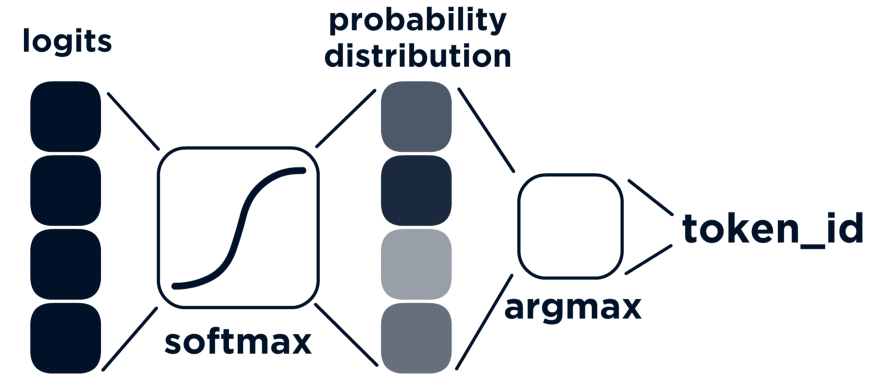

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

tokenizer_dir = '/content/drive/MyDrive/dacon/KoreanLanguage/tokenizer/32000_special'
tokenizer = BertTokenizer.from_pretrained(tokenizer_dir)
mlm_model = BertForMaskedLM.from_pretrained('klue/roberta-large')


Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-large were not used when initializing BertForMaskedLM: ['roberta.encoder.layer.5.attention.output.dense.bias', 'roberta.encoder.layer.5.intermediate.dense.weight', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.5.attention.self.value.weight', 'roberta.encoder.layer.5.attention.self.key.weight', 'roberta.encoder.layer.5.attention.output.LayerNorm.bias', 'lm_head.layer_norm.weight', 'roberta.encoder.layer.12.output.LayerNorm.bias', 'roberta.encoder.layer.19.attention.self.key.weight', 'roberta.encoder.layer.23.attention.output.dense.bias', 'roberta.encoder.layer.19.output.dense.weight', 'roberta.encoder.layer.3.intermediate.dense.weight', 'roberta.encoder.layer.7.attention.self.query.weight', 'roberta.encoder.layer.9.output.LayerNorm.bias', 'roberta.encoder.layer.6.attention.self.value.weight', 'roberta.encoder.layer.23.output.dense.weight', 'roberta.encoder.layer.10.attention.self.value.weight', 'roberta.enc

In [ ]:
def tokenize_text(text, tokenizer):
  inputs = tokenizer(text, return_tensors = 'pt')
  return inputs

def create_labels(inputs):
  inputs['labels'] = inputs.input_ids.detach().clone()
  return inputs

def create_masks(inputs):
  """
  dictionary의 형태로 이루어진 input의 input_Id의 크기와 동일하게 
  random하게 실수를 생성하고 0.15, 즉 mlm probability보다 작으면 masking
  """
  rand = torch.rand(inputs.input_ids.shape)
  mask_arr = (rand < 0.15) * (inputs.input_ids != 0) * (inputs.input_ids != 1) * (inputs.input_ids != 2) *\
              (inputs.input_ids != 3) * (inputs.input_ids != 5) * (inputs.input_ids != 6)
  return mask_arr

In [ ]:
# 0(UNK),1(SEP),2(PAD),3(CLS),4(MASK), 5(BOS), 6(EOS)
# special token에 대해서는 하면 안됨

with open('/content/drive/MyDrive/dacon/KoreanLanguage/data/CORPUS/ko_corpus_mecab.txt', 'r', encoding='utf-8') as f:
  text = f.read().split('\n')


In [ ]:
splited_text_path = '/content/drive/MyDrive/dacon/KoreanLanguage/data/CORPUS/corpus'
full_length = len(text)

import random
random.shuffle(text)
split_length = int(full_length // 5)
start, end = 0, split_length
for split in range(5):
  new_path = splited_text_path + f"/{split}.txt"
  with open(new_path, 'w', encoding = 'utf-8') as f:
    for idx, line in enumerate(text[start:end]):
      # 한국어 문장 말뭉치를 만들기 위해서 단어로만 이루어진 문장이 아닌 경우와 빈 문자열은 제외하고 저장하였다.
      if line != '' and line[-1] == '.':
        f.write(line)
        f.write('\n')
    start = end
    end += split_length

In [ ]:
class MLMDataset(torch.utils.data.Dataset):
  def __init__(self, text, tokenizer):
    self.text = text
    self.tokenizer = tokenizer
  
  def __len__(self):
    return len(self.text)

  def __getitem__(self, idx):
    seq = self.text[idx]
    inputs = tokenizer(seq, return_tensors = 'pt', max_length = 256, truncation = True, padding = "max_length")
    input_ids = inputs.input_ids
    att_mask = inputs.attention_mask

    labels = input_ids.clone()
    rand = torch.rand(input_ids.shape)
    # mask array 생성
    mask_arr = (rand < 0.15) * (input_ids != 0) * (input_ids != 1) * (input_ids != 2) *\
              (input_ids != 3) * (input_ids != 5) * (input_ids != 6)

    selection = torch.flatten(mask_arr.nonzero()).tolist()
    # change to mask idx
    input_ids[:,selection] = 4

    inputs = {}
    inputs['input_ids']= (input_ids)
    inputs['attention_masks'] = (att_mask)

    inputs['labels'] = (labels)
    
    return inputs

In [ ]:
class MLMSimpleDataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings
  def __getitem__(self, idx):
    return self.encodings[idx]
  def __len__(self):
    return len(self.encodings)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics(pred, labels):
    # predictions : [batch_size, max_len, vocab_size] = [8, 256, 32000]
    # labels : [batch_size, max_len]

    # preds = pred.argmax(-1, keepdim = False)

    preds = pred.detach().cpu().numpy()
    one_hot = torch.zeros_like(pred)
    labels = labels.detach().cpu().numpy()

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
def evaluate_mlm_first_step(model, eval_dataloader, device):
  model.eval()
  running_acc = 0.0
  
  pt_dir = "/content/drive/MyDrive/dacon/KoreanLanguage/ckpt/mlm"
  from tqdm import tqdm
  metric = load_metric('bertscore')
  
  eval_loop = tqdm(eval_dataloader, total = len(eval_dataloader))

  for batch in eval_loop:
    with torch.no_grad():
      input_ids = batch['input_ids'].squeeze(1).to(device)
      attention_mask = batch['attention_masks'].squeeze(1).to(device)
      labels = batch['labels'].squeeze(1).to(device)
      mask_arr = batch['mask_arr'].squeeze(1).to(device)
      outputs = model(input_ids, attention_mask = attention_mask, labels = labels, return_dict = True)
      scores = metric.compute(predictions=np.dot(outputs['logits'], mask_arr),references = labels, lang = 'ko',device=device)
      score = np.mean(scores['f1'])
      running_acc += score
      eval_loop.set_postfix({"ACC" : score})

    #metric.add_batch(predictions = outputs['logits'], references = labels)

  #results = metric.compute(lang = 'ko', device = device)

  eval_loop.set_description("EVALUATING")
  eval_loop.set_description(f"SCORE :{running_acc/len(eval_loop)}")
  torch.save(model.state_dict(), os.path.join(pt_dir, 'mlm_best_score.bin'))
  print(f"SAVED BEST SCORE MODEL ACC : {running_acc}")

In [ ]:
with open('/content/drive/MyDrive/dacon/KoreanLanguage/data/CORPUS/corpus/4.txt', encoding = 'utf-8') as f:
  text = f.read().split('\n')
print(text[:20])
del text

['박서진 ##은 한 ##국의 남자 성우 ##로 대원 ##방송 성우 ##극회 소속 * ##년 대원 ##방송 성우 ##극회 공채 * ##기 ##로 입사 ##했 ##다 ##.', '우리 ##나라 ##에서 * ##번 ##째 ##로 만들어진 남계 ##서원 ##을 비롯 ##해 지난해 인기리 ##에 방영 ##된 tvN 드라마 미스터 션 ##샤인 의 배경 ##이 됐 ##던 개평 한옥마을 등 곳곳 ##에 아름다운 문화유산 ##들 ##이 산재 ##해 있 ##다 ##.', '시설 ##에 의한 방법 ##으로 ##는 * ##선 궤조 ##, * ##선 궤조 방식 ##이 존재 ##한다 ##. 이 방법 ##은 기 ##존의 궤간 안쪽 또는 바깥쪽 ##에 추가 ##적 ##인 레일 ##을 설치 ##하 ##여 ##, 다른 궤 ##간의 차량 ##이 운행 ##할 수 있 ##도록 조처 ##하 ##는 방식 ##이 ##다 ##. 세 개의 레일 ##을 설치 ##하 ##여 한 레일 ##은 두 궤 ##간의 차량 ##이 공유 ##하 ##는 방법 ##을 * ##선 궤조 방식 ##이 ##라고 하 ##며 ##, 같 ##은 구간 ##에서 서로 별 ##개의 레일 ##을 사용 ##하 ##는 방식 ##을 * ##선 궤조 방식 ##이 ##라고 한다 ##.', '국회 인사 ##청문 과정 ##에서 박영선 중소 ##벤처 ##기업 ##부 장관 후보 ##자 ##가 특혜 진료 ##를 받 ##았 ##다는 의혹 ##이 제기 ##된 서울대 ##병원 ##이 실제로 별 ##도의 VIP ##실 을 운영 ##했 ##던 것 ##으로 확인 ##됐 ##다 ##.', '공항 운영 ##에 대한 외부 요인 ##의 중요 ##성 ##이 증가 ##하 ##기 때문 ##에 정부 ##, 항공사 ##, 제조 ##업체 및 기타 관련 당사자 ##들 ##과 ##의 공식 ##적 ##인 관계 ##의 필요 ##성 ##이 더욱 분명 ##해진다 ##. * ##년 ##, 이 ##들 * ##개 협회 ##는 공항 ##산업 정책 ##을 수립 ##하 ##고 ##, 공항 ##산업 정책 ##을 

In [ ]:
from datasets import load_metric

def train_mlm(model, optimizer,  scheduler ,train_dataloader, num_epoch,device, split, best_loss):
  from tqdm import tqdm

  pt_dir = "/content/drive/MyDrive/dacon/KoreanLanguage/ckpt/mlm"
  best_weight = model.state_dict()

  metric = load_metric('bertscore')
  for epoch in range(num_epoch):
    running_loss = 0.0
    running_acc = 0.0
    train_loop = tqdm(train_dataloader)
    model.train()
    idx = 1
    for batch in train_loop:
      optimizer.zero_grad()
      input_ids = batch['input_ids'].squeeze(1).to(device)
      attention_mask = batch['attention_masks'].squeeze(1).to(device)
      labels = batch['labels'].to(device)
      outputs = model(input_ids, attention_mask = attention_mask, labels = labels.squeeze(1), return_dict = True)

      loss = outputs.loss
      running_loss += loss.item()
      # score = metric.compute(predictions = outputs['logits'], references=labels.squeeze(1),  lang = 'ko', device = device)
      # running_acc += np.mean(score['f1'])

      loss.backward()
      optimizer.step()
      scheduler.step()
      train_loop.set_description(f"SPLIT : {split} EPOCH : {epoch} LR : {optimizer.state_dict()['param_groups'][0]['lr']}")
      train_loop.set_postfix({'loss' : loss.item(),
                              'running loss' : running_loss / idx, 
                              'lr' : scheduler.get_last_lr()})
      idx += 1

    running_loss /= len(train_loop)
    # running_acc /= len(train_loop)

    if (best_loss > running_loss):
      best_loss = running_loss
      torch.save(model.state_dict(), os.path.join(pt_dir, 'mlm_best_loss.bin'))
      print(f'SAVED BEST LOSS MODEL {running_loss}')

    """
    model.eval()
    running_acc = 0.0
    eval_loop = tqdm(eval_dataloader, total = len(eval_dataloader))

    for batch in eval_loop:
      with torch.no_grad():
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_masks'].squeeze(1).to(device)
        labels = batch['labels'].squeeze(1).to(device)
        outputs = model(input_ids, attention_mask = attention_mask, labels = labels, return_dict = True)
        results = metric.compute(predictions = outputs['logits'], references = labels,lang = 'ko', device = device)
        running_acc += np.mean(results['f1'])

      eval_loop.set_description("EVALUATING")
      eval_loop.set_postfix({"ACC" : np.mean(results['f1'])})

    running_acc = running_acc / len(eval_loop)
    if running_acc > best_score:
      best_score = running_acc
      torch.save(model.state_dict(), os.path.join(pt_dir, 'mlm_best_score.bin'))
      print(f"SAVED BEST ACC MODEL ACC : {running_acc}")
    """
  
  return best_loss, model


In [ ]:
from transformers import AdamW, AutoModelForMaskedLM
import gc, copy

# 따로 정확도 측정은 하지 않고 계산을 하는 중이다...

def mlm_train(start):
  device = torch.device('cuda')
  n_epochs = 1
  best_acc = -np.inf
  best_loss = np.inf

  mlm_model = AutoModelForMaskedLM.from_pretrained('klue/roberta-large')
  mlm_model.to(device)
  if os.path.isdir('/content/drive/MyDrive/dacon/KoreanLanguage/ckpt/mlm/mlm_best_loss.bin'):
    mlm_model.load_state_dict(torch.load('/content/drive/MyDrive/dacon/KoreanLanguage/ckpt/mlm/mlm_best_loss.bin'))

  tokenizer_dir = '/content/drive/MyDrive/dacon/KoreanLanguage/tokenizer/32000_special'
  tokenizer = BertTokenizer.from_pretrained(tokenizer_dir)

  text_path = '/content/drive/MyDrive/dacon/KoreanLanguage/data/CORPUS/corpus'

  for split in range(start, 5):
    gc.collect()
    torch.cuda.empty_cache()
    new_path = text_path + f'/{split}.txt'
    with open(new_path, 'r', encoding = 'utf-8') as f:
      text = f.read().split('\n')
    sizes = [int(len(text) // 2), -int(len(text) // 2)]
    for i in range(2):
      train_dataset = MLMDataset(text[:sizes[i]], tokenizer)
      train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 8, shuffle = True)

    # eval_dataset = MLMDataset(text[train_size:], tokenizer)
    # eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size = 8, shuffle = False)

    mlm_optimizer = AdamW(mlm_model.parameters(), lr = 5e-5)
    mlm_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(mlm_optimizer, T_max = 100, eta_min = 1e-6, verbose = False)
    best_loss, mlm_model = train_mlm(mlm_model, mlm_optimizer,mlm_scheduler, train_dataloader, n_epochs, device, split, best_loss)
    del text

In [ ]:
mlm_train(4)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Downloading:   0%|          | 0.00/2.92k [00:00<?, ?B/s]

SPLIT : 4 EPOCH : 0 LR : 4.111688774901454e-05: 100%|██████████| 37028/37028 [13:56:10<00:00,  1.35s/it, loss=2.56, running loss=1.69, lr=[4.111688774901454e-05]]


SAVED BEST LOSS MODEL 1.6940054818121617


### THE SEQUENCE CLASSIFICATION TASK

In [ ]:
# utils.py
import konlpy
from konlpy.tag import Mecab

def make_seq(sen1, sen2):
  seq = '[CLS]' + sen1 + '[SEP]' + sen2 + '[SEP]'
  return [seq]

def preprocessing(text):
  import re
  # 괄호와 그 내부에 있는 내용은 모두 없애줌 -> train데이터에도 없을 예정이기 때문이다.
  regex = "\([^)]*\)"
  text = re.sub(regex, '', text)

  # 영어, 숫자, 한글 이외에는 모두 제거
  # 정규 표현식 처리할때에 주의하도록 하자 -> 힗으로 표현해서 틀림
  text =  re.sub('[^0-9a-zA-Zㄱ-힣.,!?]',' ',text)
  # 숫자 정보는 모두 *으로 대체
  text = re.sub('[0-9]+','*', text)
  return text

def join_mecab(text):
  mecab = Mecab()
  morph_sentence = []
  texts = text.split(' ')
  for t in texts:
    cnt = 0
    morphs = mecab.morphs(t)
    for tok in morphs:
      save_tok = tok
      if cnt > 0:
        save_tok = '##' + save_tok
        morph_sentence.append(save_tok)
      else:
        morph_sentence.append(save_tok)
        cnt += 1
  return(' '.join(morph_sentence))

In [ ]:
tokenizer.tokenize(preprocessing(data['premise']))

In [ ]:
train, test = load_dacon_data()
data = train.iloc[99]
premise, hypothesis = preprocessing(data['premise']), preprocessing(data['hypothesis'])
    # pretraining dataset을 전처리 한 것과 동일하게 train용 데이터에도 전처리를 실행해 준다.
seq = make_seq(premise, hypothesis)

tokenizer_dir = '/content/drive/MyDrive/dacon/KoreanLanguage/tokenizer/32000_special'
tokenizer = BertTokenizer.from_pretrained('klue/roberta-large')
inputs = tokenizer(seq, max_length = 256, padding = 'max_length', truncation = True, return_tensors = 'pt')
inputs

{'input_ids': tensor([[    0,     0, 22498,  2079, 14889,  2179,  1119,  1654,  2118,  2259,
          3638,  2079,  8900,  2052,  4654,  2052, 23548,   575,  2069,  5229,
          6233,  3776,  2088, 21132,  2138,  1363,  2088, 29151,  2069,  9878,
          2259,   575,  2069,  4545,  2079,   718,  6233,  1238,  2259,  2062,
            18,     2,  1119,  1654,  2118,  2259, 29151,  2069,  9878,  2259,
           575,  2069,  6582, 19661,  2318, 20328,    18,     2,     2,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,  

In [ ]:
# dataset.py
labels = ['contradiction', 'neutral', 'entailment']

label_encoder = {key : item for key, item in zip(labels, range(3))}
label_decoder = {key : item for key, item in zip(range(3), labels)}

class KoSDataset(torch.utils.data.Dataset):
  def __init__(self,text,fold, tokenizer, train_mode = True, test_mode = False):
    """
    train_mode : False이면 validation 데이터를 사용해야 한다.
    """
    self.tokenizer = tokenizer
    self.train_mode = train_mode
    self.test_mode = test_mode
    if self.test_mode:
      self.data = text
    elif self.train_mode:
      self.data = text[text['fold'] != fold]
    elif not self.train_mode:
      self.data = text[text['fold'] == fold]
  
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    data = self.data.iloc[idx]
    premise, hypothesis = data['premise'], data['hypothesis']
    premise, hypothesis = preprocessing(data['premise']), preprocessing(data['hypothesis'])
    # pretraining dataset을 전처리 한 것과 동일하게 train용 데이터에도 전처리를 실행해 준다.
    seq = make_seq(premise, hypothesis)

    inputs = self.tokenizer(seq, max_length = 256, padding = 'max_length', truncation = True, return_tensors = 'pt')
    if not self.test_mode:
      inputs['labels'] = torch.tensor(label_encoder[data['label']], dtype = torch.long)
    return inputs

In [ ]:
# 별차이는 없을 수도 있으나 우선은 accuracy가 제일 높았던 모델에 대해서 5fold로 시험해 보고자 한다.
# network.py
class KoSBERT(nn.Module):
  def __init__(self, bert_model, linear_dim, reinit_pooler = False, reinit_layers = 0, layers_used = 4,
               stack_dropout_p = 0.1, linear_dropout_p = 0.5, num_labels = 3,
               ):
    super().__init__()

    self.bert = bert_model

    self.dropout_bert_stack = nn.Dropout(p = stack_dropout_p)
    
    hidden_d = self.bert.config.hidden_size # 1024
    # POOLER
    self.pooler = nn.AdaptiveAvgPool1d(output_size = 1024)

    # CNN 1D
    self.cnn = nn.Sequential(
      nn.Conv1d(hidden_d, 2*hidden_d, kernel_size = 5, stride = 2, padding = 2),
      nn.BatchNorm1d(2*hidden_d),
      nn.LeakyReLU(),
      nn.Conv1d(2*hidden_d, 4*hidden_d, kernel_size = 5, stride = 2, padding = 2),
      nn.BatchNorm1d(4*hidden_d),
      nn.LeakyReLU()
      )
    
    # LINEAR
    lin_size = hidden_d * (1 + 4) # (cnn + hidden_state)

    self.linear = nn.Sequential(
        nn.Linear(lin_size, lin_size),
        nn.ReLU(),
        nn.Linear(lin_size, num_labels)
    )

    with torch.no_grad():
      if reinit_pooler:
        self.bert.pooler.dense.weight.data.normal_(mean = 0.0, std = self.bert.config.initializer_range)
        self.bert.pooler.dense.bias.data.zero_() 
        for p in self.bert.pooler.parameters():
          p.requires_grad = True

      if reinit_layers > 0:
        layers = self.bert.encoder.layer[-reinit_layers:]
        for layer in layers:
          for module in layer.modules():
            if isinstance(module, nn.Linear):
              module.weight.data.normal_(mean = 0.0, std = self.bert.config.initializer_range)
              if module.bias is not None:
                module.bias.data.zero_()
            elif isinstance(module, nn.LayerNorm):
              module.bias.data.zero_()
              module.weight.data.fill_(1.0)

  def forward(self, input_ids, attention_mask):
    x = self.bert(input_ids, attention_mask, output_hidden_states = True)
    hidden_states, logits = x.hidden_states, x.logits
    # (25, batch, L, 1024) (batch, L, 1024) 
    pooled = self.pooler(logits)

    # 문장의 전체적인 내용을 확인하기 위해서 사용
    h = torch.stack([self.dropout_bert_stack(x) for x in hidden_states[-4:]]).mean(dim = 0) # (B, L, 1024)
    x = torch.sum(h * attention_mask[..., None], dim = 1) # (B, L, 1024) * (B, L, 1) -> (B,1024)
    x /=  torch.sum(attention_mask, dim = -1, keepdim = True) # (B,1024) / (B,1) -> (B,1024)

    pooled = torch.sum(pooled * attention_mask[...,None], dim = 1, keepdim = True)
    pooled /=  torch.sum(pooled, dim = -1, keepdim = True)
    z = self.cnn(pooled.transpose(1,2)).mean(2) 
    x = torch.cat([x,z],dim = 1)
    x = self.linear(x)

    return x


In [ ]:
# lookahead.py
class Lookahead(Optimizer):
    def __init__(self, optimizer, k=5, alpha=0.5):
        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha
        self.param_groups = self.optimizer.param_groups
        self.state = defaultdict(dict)
        self.fast_state = self.optimizer.state
        for group in self.param_groups:
            group["counter"] = 0

    def update(self, group):
        for fast in group["params"]:
            param_state = self.state[fast]
            if "slow_param" not in param_state:
                param_state["slow_param"] = torch.zeros_like(fast.data)
                param_state["slow_param"].copy_(fast.data)
            slow = param_state["slow_param"]
            slow += (fast.data - slow) * self.alpha
            fast.data.copy_(slow)

    def update_lookahead(self):
        for group in self.param_groups:
            self.update(group)

    def step(self, closure=None):
        loss = self.optimizer.step(closure)
        for group in self.param_groups:
            if group["counter"] == 0:
                self.update(group)
            group["counter"] += 1
            if group["counter"] >= self.k:
                group["counter"] = 0
        return loss

    def state_dict(self):
        fast_state_dict = self.optimizer.state_dict()
        slow_state = {(id(k) if isinstance(k, torch.Tensor) else k): v for k, v in self.state.items()}
        fast_state = fast_state_dict["state"]
        param_groups = fast_state_dict["param_groups"]
        return {
            "fast_state": fast_state,
            "slow_state": slow_state,
            "param_groups": param_groups,
        }

    def load_state_dict(self, state_dict):
        slow_state_dict = {
            "state": state_dict["slow_state"],
            "param_groups": state_dict["param_groups"],
        }
        fast_state_dict = {
            "state": state_dict["fast_state"],
            "param_groups": state_dict["param_groups"],
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.optimizer.load_state_dict(fast_state_dict)
        self.fast_state = self.optimizer.state

    def add_param_group(self, param_group):
        param_group["counter"] = 0
        self.optimizer.add_param_group(param_group)

In [ ]:
# VALIDATION
from tqdm import tqdm
from sklearn.metrics import f1_score

def run_valid(model, valid_dataloader):
  model.eval()
  running_loss = 0.0
  label_list, pred_list = [], []
  criterion = nn.CrossEntropyLoss()

  eval_loop = tqdm(valid_dataloader)
  for data in eval_loop:
    ids = data['input_ids'].squeeze(1).to(device)
    att_mask = data['attention_mask'].squeeze(1).to(device)
    label = data['labels'].to(device)
    
    with torch.no_grad():
      with amp.autocast():
        outputs = model(ids, att_mask)
        loss = criterion(outputs, label)
      running_loss += loss
      eval_loop.set_postfix({'loss' : loss.item()})
      label_list.extend(label.detach().cpu().numpy())
      pred_list.extend(outputs.argmax(dim = 1).tolist())

    val_mean_loss = running_loss / len(valid_dataloader)
    val_score = f1_score(label_list, pred_list, average = 'macro')
    val_acc = accuracy_score(label_list, pred_list)
  
  return val_mean_loss, val_score, val_acc

In [ ]:
def manage_grad(model):
  for name, module in model.bert.named_modules():
    if isinstance(module, nn.LayerNorm):
      for param in module.parameters():
        param.requires_grad = True
    else:
      for param in module.parameters():
        param.requires_grad = False
  return model

def manage_second_grad(model):
  for named, module in model.bert.named_modules():
    if isinstance(module,nn.LayerNorm):
      for param in module.parameters():
        param.requires_grad = False
    else:
      for param in module.parameters():
        param.requires_grad = True
  return model

In [ ]:
# TRAINING
from torch.cuda.amp.grad_scaler import OptState as OptState
from transformers import AutoModelForMaskedLM
from tqdm import tqdm
from transformers import BertTokenizer
def run_train(fold):
  os.makedirs(args.out_dir, exist_ok = True)
  train, test = load_dacon_data()
  ## make dataloaders
  tokenizer_dir = '/content/drive/MyDrive/dacon/KoreanLanguage/tokenizer/32000_special'
  # tokenizer = BertTokenizer.from_pretrained(tokenizer_dir)

  tokenizer = BertTokenizer.from_pretrained('klue/roberta-large')
  train_dataset = KoSDataset(train,fold, tokenizer, train_mode = True)
  valid_dataset = KoSDataset(train, fold, tokenizer, train_mode = False)

  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 8, shuffle = True)
  valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size = 8, shuffle = False)

  ## model
  scaler = amp.GradScaler()
  bert = AutoModelForMaskedLM.from_pretrained('klue/roberta-large')
  # bert.load_state_dict(torch.load('/content/drive/MyDrive/dacon/KoreanLanguage/ckpt/mlm/mlm_best_loss.bin'))

  model = KoSBERT(bert, args.linear_dim,)
  ckpt_pth = os.path.join('/content/drive/MyDrive/dacon/KoreanLanguage/ckpt/roberta', f'ixxi_{fold}.bin')
  if os.path.isfile(ckpt_pth):
    model.load_state_dict(torch.load(ckpt_pth))  

  model.to(device)
  # model = manage_grad(model)
  ## loss
  criterion = nn.CrossEntropyLoss()

  ## optimizer
  #optimizer = torch.optim.AdamW(filter(lambda p : p.requires_grad, model.parameters()), lr = 5e-5)
  #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 500, eta_min = 1e-6)
  #scheduler = None
  optimizer = Lookahead(torch.optim.RAdam(filter(lambda p: p.requires_grad,model.parameters()), lr=5e-5), alpha=0.5, k=5)
  #scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, num_warmup_steps = 100, num_training_steps = len(train_dataloader) * 10, num_cycles = 500)
  scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = 100, num_training_steps = len(train_dataloader)*10)
  start_lr = 5e-5

  ## start training & validation
  start_timer = timer()
  best_acc = -np.inf
  best_epoch = -1
  best_loss = np.inf

  for epoch in range(1, 14+1):
    if (epoch == 10):
      model = manage_second_grad(model)
      optimizer = Lookahead(torch.optim.RAdam(filter(lambda p: p.requires_grad,model.parameters()), lr=1e-5), alpha=0.5, k=5)
      scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 500, num_training_steps = len(train_dataloader)*5)
      # scheduler = None

    gc.collect()
    torch.cuda.empty_cache()
    train_loss = 0.0
    valid_loss = 0.0

    label_list, pred_list = [], []
    lr = optimizer.state_dict()['param_groups'][0]['lr']

    print(">>>>>>>>>>>>>>>>>>>>")
    print(f"FOLD : {fold} EPOCH : {epoch} START LR : {lr}")
    print("<<<<<<<<<<<<<<<<<<<<")

    train_loop = tqdm(train_dataloader)
    model.train()
    for data in train_loop:
      ids = data['input_ids'].squeeze(1).to(device)
      att_mask = data['attention_mask'].squeeze(1).to(device)
      label = data['labels'].to(device)
      optimizer.zero_grad()

      with amp.autocast():
        output = model(ids, att_mask)
        loss = criterion(output, label)
        train_loss += loss

      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      scheduler.step()

      train_loop.set_postfix({'loss' : loss.item(),
                              'lr' : optimizer.state_dict()['param_groups'][0]['lr']})

      label_list.extend(label.detach().cpu().numpy())
      pred_list.extend(output.argmax(dim = 1).tolist())
      
    # optimizer이 forward step을 진행한 상태이면 scheduler을 적용
    """
    if scaler._per_optimizer_states[id(optimizer)]["stage"] is OptState.STEPPED and scheduler is not None:
      print("SCHEDULER ENABLED")
      scheduler.step()
    """
 
    train_loss /= len(train_dataloader)
    train_score = f1_score(label_list, pred_list, average = 'macro')
    train_acc = accuracy_score(label_list, pred_list)

    # valid step
    val_loss, val_score, val_acc = run_valid(model, valid_dataloader)

    if val_acc > best_acc:
      best_acc = val_acc
      best_epoch = epoch
      best_loss = valid_loss

      torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/dacon/KoreanLanguage/ckpt/roberta', f"ixxi_{fold}.bin"))
      print("SAVED BEST MODEL")
    
    print(f"TRAIN LOSS : {train_loss : .4f}  TRAIN F1 SCORE : {train_score : .4f} TRAIN ACC : {train_acc : .4f}")
    print(f"VALID LOSS : {val_loss : .4f} VALID F1 SCORE : {val_score : .4f}  VALID ACC : {val_acc : .4f}")
  
  print(f"BEST VALID LOSS : {best_loss : .4f} BEST ACC ; {best_acc : .4f} BEST EPOCH : {best_epoch}")

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

last_stopped = 4
for fold in range(last_stopped, 5):
  run_train(fold)

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

>>>>>>>>>>>>>>>>>>>>
FOLD : 4 EPOCH : 1 START LR : 0.0
<<<<<<<<<<<<<<<<<<<<


  0%|          | 0/2500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 625/625 [02:56<00:00,  3.55it/s, loss=0.356]


SAVED BEST MODEL
TRAIN LOSS :  0.4487  TRAIN F1 SCORE :  0.8292 TRAIN ACC :  0.8300
VALID LOSS :  0.3587 VALID F1 SCORE :  0.8700  VALID ACC :  0.8704
>>>>>>>>>>>>>>>>>>>>
FOLD : 4 EPOCH : 2 START LR : 4.886260156928888e-05
<<<<<<<<<<<<<<<<<<<<


100%|██████████| 625/625 [02:56<00:00,  3.55it/s, loss=0.0785]


TRAIN LOSS :  0.2847  TRAIN F1 SCORE :  0.8961 TRAIN ACC :  0.8964
VALID LOSS :  0.3730 VALID F1 SCORE :  0.8587  VALID ACC :  0.8602
>>>>>>>>>>>>>>>>>>>>
FOLD : 4 EPOCH : 3 START LR : 4.537271191107585e-05
<<<<<<<<<<<<<<<<<<<<


100%|██████████| 625/625 [02:55<00:00,  3.56it/s, loss=0.126]


SAVED BEST MODEL
TRAIN LOSS :  0.1859  TRAIN F1 SCORE :  0.9319 TRAIN ACC :  0.9320
VALID LOSS :  0.3522 VALID F1 SCORE :  0.8727  VALID ACC :  0.8728
>>>>>>>>>>>>>>>>>>>>
FOLD : 4 EPOCH : 4 START LR : 3.987268253070273e-05
<<<<<<<<<<<<<<<<<<<<


100%|██████████| 625/625 [02:55<00:00,  3.56it/s, loss=0.00167]


TRAIN LOSS :  0.1133  TRAIN F1 SCORE :  0.9612 TRAIN ACC :  0.9612
VALID LOSS :  0.5045 VALID F1 SCORE :  0.8721  VALID ACC :  0.8728
>>>>>>>>>>>>>>>>>>>>
FOLD : 4 EPOCH : 5 START LR : 3.29051916724206e-05
<<<<<<<<<<<<<<<<<<<<


100%|██████████| 625/625 [02:55<00:00,  3.57it/s, loss=0.000422]


SAVED BEST MODEL
TRAIN LOSS :  0.0700  TRAIN F1 SCORE :  0.9758 TRAIN ACC :  0.9758
VALID LOSS :  0.4911 VALID F1 SCORE :  0.8807  VALID ACC :  0.8814
>>>>>>>>>>>>>>>>>>>>
FOLD : 4 EPOCH : 6 START LR : 2.5157709428534936e-05
<<<<<<<<<<<<<<<<<<<<


100%|██████████| 625/625 [02:55<00:00,  3.56it/s, loss=0.00581]


SAVED BEST MODEL
TRAIN LOSS :  0.0453  TRAIN F1 SCORE :  0.9856 TRAIN ACC :  0.9855
VALID LOSS :  0.4651 VALID F1 SCORE :  0.8829  VALID ACC :  0.8834
>>>>>>>>>>>>>>>>>>>>
FOLD : 4 EPOCH : 7 START LR : 1.739466627217767e-05
<<<<<<<<<<<<<<<<<<<<


100%|██████████| 625/625 [02:55<00:00,  3.56it/s, loss=0.00099]


SAVED BEST MODEL
TRAIN LOSS :  0.0221  TRAIN F1 SCORE :  0.9930 TRAIN ACC :  0.9929
VALID LOSS :  0.6008 VALID F1 SCORE :  0.8832  VALID ACC :  0.8838
>>>>>>>>>>>>>>>>>>>>
FOLD : 4 EPOCH : 8 START LR : 1.0382028044398822e-05
<<<<<<<<<<<<<<<<<<<<


100%|██████████| 625/625 [02:55<00:00,  3.56it/s, loss=2.17e-5]


SAVED BEST MODEL
TRAIN LOSS :  0.0090  TRAIN F1 SCORE :  0.9973 TRAIN ACC :  0.9973
VALID LOSS :  0.7167 VALID F1 SCORE :  0.8865  VALID ACC :  0.8870
>>>>>>>>>>>>>>>>>>>>
FOLD : 4 EPOCH : 9 START LR : 4.811719449200755e-06
<<<<<<<<<<<<<<<<<<<<


100%|██████████| 625/625 [02:55<00:00,  3.56it/s, loss=3.07e-5]


SAVED BEST MODEL
TRAIN LOSS :  0.0042  TRAIN F1 SCORE :  0.9985 TRAIN ACC :  0.9985
VALID LOSS :  0.7480 VALID F1 SCORE :  0.8886  VALID ACC :  0.8892
>>>>>>>>>>>>>>>>>>>>
FOLD : 4 EPOCH : 10 START LR : 0.0
<<<<<<<<<<<<<<<<<<<<


100%|██████████| 625/625 [02:55<00:00,  3.56it/s, loss=1.43e-5]


TRAIN LOSS :  0.0058  TRAIN F1 SCORE :  0.9982 TRAIN ACC :  0.9981
VALID LOSS :  0.7693 VALID F1 SCORE :  0.8881  VALID ACC :  0.8888
>>>>>>>>>>>>>>>>>>>>
FOLD : 4 EPOCH : 11 START LR : 8.333333333333334e-06
<<<<<<<<<<<<<<<<<<<<


100%|██████████| 625/625 [02:55<00:00,  3.56it/s, loss=0.000218]


TRAIN LOSS :  0.0075  TRAIN F1 SCORE :  0.9979 TRAIN ACC :  0.9979
VALID LOSS :  0.7144 VALID F1 SCORE :  0.8862  VALID ACC :  0.8868
>>>>>>>>>>>>>>>>>>>>
FOLD : 4 EPOCH : 12 START LR : 6.25e-06
<<<<<<<<<<<<<<<<<<<<


100%|██████████| 625/625 [02:55<00:00,  3.56it/s, loss=7.44e-5]


TRAIN LOSS :  0.0037  TRAIN F1 SCORE :  0.9987 TRAIN ACC :  0.9987
VALID LOSS :  0.8153 VALID F1 SCORE :  0.8876  VALID ACC :  0.8884
>>>>>>>>>>>>>>>>>>>>
FOLD : 4 EPOCH : 13 START LR : 4.166666666666667e-06
<<<<<<<<<<<<<<<<<<<<


100%|██████████| 625/625 [02:55<00:00,  3.56it/s, loss=2.1e-5]


TRAIN LOSS :  0.0037  TRAIN F1 SCORE :  0.9989 TRAIN ACC :  0.9989
VALID LOSS :  0.8180 VALID F1 SCORE :  0.8868  VALID ACC :  0.8874
>>>>>>>>>>>>>>>>>>>>
FOLD : 4 EPOCH : 14 START LR : 2.0833333333333334e-06
<<<<<<<<<<<<<<<<<<<<


100%|██████████| 625/625 [02:55<00:00,  3.56it/s, loss=1.85e-5]


SAVED BEST MODEL
TRAIN LOSS :  0.0020  TRAIN F1 SCORE :  0.9991 TRAIN ACC :  0.9991
VALID LOSS :  0.8293 VALID F1 SCORE :  0.8898  VALID ACC :  0.8904
BEST VALID LOSS :  0.0000 BEST ACC ;  0.8904 BEST EPOCH : 14


### EVALUATION

In [ ]:
encoder = {0 : 'entailment', 1 : 'contradiction', 2 : 'neutral'}

In [ ]:
answer = [1, 2, 0, 1, 1, 2, 2, 0, 0, 2, 2, 0, 1, 0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 0, 1, 1, 0, 0, 0, 2, 1, 0, 1, 2, 2, 1, 2, 1, 0, 1, 2, 0, 2, 2, 2, 1, 2, 0, 1, 0, 0, 1, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 0, 1, 2, 2, 0, 2, 2, 2, 2, 1, 1, 2, 0, 1, 2, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 1, 0, 2, 2, 0, 2, 1, 2, 0, 2, 2, 1, 0, 1, 2, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 1, 2, 1, 2, 1, 0, 2, 0, 1, 2, 1, 1, 2, 2, 1, 0, 2, 2, 0, 1, 2, 1, 1, 0, 1, 2, 0, 0, 0, 1, 1, 2, 2, 0, 2, 1, 2, 1, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2, 1, 2, 0, 1, 2, 2, 1, 0, 2, 0, 0, 2, 1, 2, 2, 2, 0, 1, 1, 0, 0, 2, 0, 2, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 2, 2, 0, 1, 2, 1, 1, 2, 2, 1, 0, 2, 1, 0, 0, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 0, 2, 2, 2, 1, 0, 1, 2, 0, 1, 2, 1, 1, 0, 0, 0, 0, 1, 2, 2, 2, 1, 0, 2, 0, 2, 2, 0, 0, 2, 1, 1, 2, 2, 2, 2, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 1, 2, 0, 2, 0, 2, 0, 0, 0, 2, 1, 1, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 1, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 2, 1, 2, 0, 1, 2, 1, 1, 1, 2, 1, 2, 2, 0, 1, 2, 1, 1, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 1, 2, 0, 1, 0, 0, 2, 1, 2, 0, 1, 1, 1, 2, 0, 2, 1, 0, 1, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 2, 2, 0, 2, 0, 2, 2, 1, 1, 1, 0, 2, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 0, 1, 2, 1, 0, 0, 1, 1, 0, 2, 1, 2, 0, 0, 0, 1, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 2, 2, 0, 0, 1, 0, 2, 2, 0, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2, 2, 1, 2, 2, 1, 0, 0, 1, 0, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0, 1, 2, 1, 0, 2, 0, 2, 1, 0, 0, 0, 2, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 0, 2, 1, 2, 1, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 1, 0, 1, 1, 1, 2, 0, 0, 1, 2, 2, 0, 2, 2, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 2, 2, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 0, 1, 0, 2, 0, 2, 2, 1, 0, 0, 1, 1, 0, 2, 0, 2, 0, 2, 1, 1, 2, 0, 1, 1, 0, 2, 2, 0, 1, 0, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1, 2, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 1, 0, 1, 1, 2, 2, 2, 0, 2, 0, 0, 0, 1, 2, 2, 0, 0, 0, 2, 1, 2, 1, 2, 1, 1, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 1, 2, 2, 1, 2, 1, 2, 2, 2, 0, 0, 2, 2, 1, 2, 2, 0, 2, 0, 1, 2, 0, 2, 0, 1, 2, 1, 2, 0, 0, 2, 2, 1, 0, 2, 2, 0, 2, 1, 2, 0, 0, 1, 2, 0, 1, 0, 1, 0, 2, 2, 0, 1, 0, 0, 2, 0, 1, 2, 2, 1, 1, 0, 0, 1, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 2, 2, 2, 1, 2, 1, 0, 0, 1, 1, 2, 2, 0, 2, 1, 2, 1, 1, 0, 1, 0, 2, 2, 1, 1, 0, 2, 2, 1, 0, 2, 1, 0, 0, 2, 1, 0, 1, 0, 2, 2, 2, 0, 0, 2, 1, 2, 1, 2, 0, 0, 2, 2, 0, 1, 2, 2, 2, 2, 1, 0, 0, 1, 2, 2, 0, 2, 0, 1, 0, 0, 1, 2, 0, 2, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 2, 0, 2, 2, 2, 0, 2, 2, 1, 1, 2, 1, 2, 0, 0, 0, 2, 1, 2, 0, 2, 1, 2, 0, 2, 2, 1, 1, 1, 1, 0, 1, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 1, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 2, 1, 1, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 1, 1, 2, 1, 0, 0, 2, 1, 2, 0, 2, 1, 1, 0, 2, 0, 0, 2, 2, 1, 0, 0, 2, 2, 2, 0, 0, 1, 2, 0, 0, 0, 2, 1, 0, 2, 0, 2, 0, 2, 2, 2, 1, 1, 0, 2, 0, 0, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 0, 1, 0, 0, 2, 1, 2, 1, 0, 2, 2, 2, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 1, 0, 1, 2, 1, 0, 0, 1, 1, 0, 0, 1, 2, 1, 1, 2, 2, 2, 0, 0, 1, 1, 1, 2, 1, 2, 2, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 0, 2, 0, 2, 0, 1, 0, 1, 2, 0, 0, 2, 2, 2, 2, 2, 0, 1, 1, 1, 2, 0, 2, 0, 2, 2, 1, 2, 1, 2, 2, 0, 2, 1, 2, 1, 2, 0, 1, 2, 1, 2, 2, 2, 2, 1, 0, 0, 1, 2, 0, 2, 1, 2, 1, 0, 2, 1, 0, 2, 2, 2, 1, 1, 1, 1, 2, 0, 0, 1, 2, 1, 2, 0, 2, 2, 1, 1, 2, 2, 0, 1, 2, 0, 0, 2, 1, 1, 0, 2, 1, 0, 0, 1, 0, 2, 2, 2, 1, 1, 0, 1, 1, 1, 2, 0, 2, 0, 2, 1, 2, 1, 0, 0, 1, 0, 2, 0, 0, 2, 2, 2, 0, 0, 1, 1, 2, 0, 1, 0, 1, 2, 2, 0, 1, 0, 1, 0, 1, 0, 2, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 0, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 0, 2, 2, 0, 2, 1, 1, 0, 2, 1, 1, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 0, 0, 2, 0, 1, 0, 2, 0, 1, 1, 0, 0, 2, 2, 2, 2, 0, 2, 1, 1, 1, 0, 1, 2, 1, 2, 2, 2, 2, 1, 2, 0, 1, 2, 1, 2, 1, 1, 2, 2, 1, 0, 2, 1, 2, 2, 0, 1, 0, 0, 1, 2, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 0, 0, 1, 1, 1, 2, 2, 0, 1, 2, 2, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 1, 1, 0, 1, 0, 2, 1, 1, 2, 1, 0, 0, 2, 0, 2, 0, 1, 1, 2, 1, 2, 1, 2, 1, 0, 0, 1, 1, 2, 2, 1, 0, 1, 2, 1, 0, 2, 2, 0, 1, 1, 1, 1, 1, 2, 0, 2, 2, 1, 1, 2, 2, 0, 2, 2, 2, 0, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 0, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0, 2, 1, 1, 2, 1, 2, 0, 1, 2, 2, 2, 2, 1, 2, 0, 1, 1, 2, 1, 2, 0, 0, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 2, 1, 0, 1, 0, 0, 1, 2, 2, 0, 1, 1, 1, 2, 2, 1, 0, 2, 1, 1, 0, 2, 2, 2, 2, 0, 0, 0, 1, 1, 2, 2, 2, 0, 0, 2, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 0, 2, 2, 0, 2, 0, 1, 2, 1, 2, 1, 2, 0, 1, 2, 1, 2, 2, 0, 1, 2, 1, 0, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 1, 1, 0, 2, 1, 1, 0, 1, 2, 2, 2, 0, 2, 0, 2, 2, 2]


In [ ]:
answer = list(map(lambda x: encoder[x], answer))

In [ ]:
from transformers import BertTokenizer, AutoModelForMaskedLM

train, test = load_dacon_data()
# tokenizer_dir = '/content/drive/MyDrive/dacon/KoreanLanguage/tokenizer/32000_special'
tokenizer = BertTokenizer.from_pretrained('klue/roberta-large')
test_dataset = KoSDataset(test, fold = None, tokenizer = tokenizer, train_mode = False, test_mode = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size = 8,shuffle = False)

bert = AutoModelForMaskedLM.from_pretrained('klue/roberta-large')

model = KoSBERT(bert, args.linear_dim).to(device)

predictions = []

for fold in range(5):
  pth = os.path.join('/content/drive/MyDrive/dacon/KoreanLanguage/ckpt/roberta', f"ixxi_{fold}.bin")
  model.load_state_dict(torch.load(pth))
  model.to(device)
  model.eval()
  prediction = []

  test_loop = tqdm(test_dataloader)
  for data in test_loop:
    ids = data['input_ids'].squeeze(1).to(device)
    att_mask = data['attention_mask'].squeeze(1).to(device)
    outputs = model(ids, att_mask)

    outputs = outputs.cpu().detach().numpy()
    outputs = np.argmax(outputs, axis = -1)
    prediction.extend(outputs)

  predictions.append(prediction)
  print(f"TEST FOLD {fold} ENDED")

100%|██████████| 209/209 [00:57<00:00,  3.63it/s]


TEST FOLD 0 ENDED


100%|██████████| 209/209 [00:57<00:00,  3.63it/s]


TEST FOLD 1 ENDED


100%|██████████| 209/209 [00:57<00:00,  3.63it/s]


TEST FOLD 2 ENDED


100%|██████████| 209/209 [00:57<00:00,  3.64it/s]


TEST FOLD 3 ENDED


100%|██████████| 209/209 [00:57<00:00,  3.64it/s]

TEST FOLD 4 ENDED


In [ ]:
import pandas as pd
submission = pd.read_csv('/content/drive/MyDrive/dacon/KoreanLanguage/data/sample_submission.csv')
submission.head()

,index,label
0,0,answer
1,1,answer
2,2,answer
3,3,answer
4,4,answer


In [ ]:
from collections import Counter
predictions = np.array(predictions).T
answer = []
for pred in predictions:
  cnt = Counter(pred)
  ans = cnt.most_common()[0][0]
  answer.append(label_decoder[ans])

submission_df = pd.DataFrame({
    'index' : submission.index,
    'label' : answer
})

submission_df.to_csv('/content/drive/MyDrive/dacon/KoreanLanguage/data/my_submission.csv', index = False)

In [ ]:
submission_df.head()

,index,label
0,0,contradiction
1,1,neutral
2,2,entailment
3,3,contradiction
4,4,contradiction


### PRACTICE

In [ ]:
tokenizer_dir = '/content/drive/MyDrive/dacon/KoreanLanguage/tokenizer/32000_special'
tokenizer = BertTokenizer.from_pretrained(tokenizer_dir)

train_dataset = KoSDataset(train,fold, tokenizer, train_mode = True)
valid_dataset = KoSDataset(train, fold, tokenizer, train_mode = False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 8, shuffle = True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size = 8, shuffle = False)

In [ ]:
data = next(iter(train_dataloader))

In [ ]:
data

In [ ]:
model = AutoModelForMaskedLM.from_pretrained('klue/roberta-large')

In [ ]:
model

In [ ]:
AutoModel.from_pretrained('klue/roberta-large')

In [ ]:
outs = model(data['input_ids'].squeeze(1), data['attention_mask'].squeeze(1), output_hidden_states = True)

In [ ]:
outs['logits'].shape

torch.Size([8, 256, 32000])

In [ ]:
outs['hidden_states'][-1].shape

torch.Size([8, 256, 1024])